In [1]:
import numpy as np 
import pandas as pd 
import scipy

from subprocess import check_output

In [2]:
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import KFold, ParameterGrid, cross_val_score
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

In [7]:
import keras as ks
from keras.models import Sequential, load_model, Model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


# Load Data

In [8]:
train = pd.read_csv('/Users/qinhuixu/Desktop/Kaggle/RussianHousing/xqh/data/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('/Users/qinhuixu/Desktop/Kaggle/RussianHousing/xqh/data/test.csv', parse_dates=['timestamp'])
macro = pd.read_csv('/Users/qinhuixu/Desktop/Kaggle/RussianHousing/xqh/data/macro.csv', parse_dates=['timestamp'])
#id_test = test.id

In [9]:
macro[100:103].T[1:15]

,100,101,102
oil_urals,82.87,82.87,82.87
gdp_quart,9995.8,9995.8,9995.8
gdp_quart_growth,4.1,4.1,4.1
cpi,319.8,319.8,319.8
ppi,350.2,350.2,350.2
gdp_deflator,NaN,NaN,NaN
balance_trade,16.604,16.604,16.604
balance_trade_growth,14.1,14.1,14.1
usdrub,29.1525,29.0261,29.1
eurrub,39.2564,39.4051,39.5008


In [10]:
train[200:203].T[1:15]

,200,201,202
timestamp,2011-10-25 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00
full_sq,38,33,30
life_sq,19,14,18
floor,15,8,3
max_floor,NaN,NaN,NaN
material,NaN,NaN,NaN
build_year,NaN,NaN,NaN
num_room,NaN,NaN,NaN
kitch_sq,NaN,NaN,NaN
state,NaN,NaN,NaN


# Solutions

In [11]:
X_list_num = ['full_sq', 'num_room', 'floor', 'timestamp',
              'preschool_education_centers_raion', 'school_education_centers_raion', 
              'children_preschool', 'children_school',
              'shopping_centers_raion', 'healthcare_centers_raion', 
              'office_raion', 'sport_objects_raion',
              'metro_min_walk', 'public_transport_station_min_walk', 
              'railroad_station_walk_min', 'cafe_count_500',
              'kremlin_km', 'workplaces_km', 'ID_metro',
              'public_healthcare_km', 'kindergarten_km', 'school_km', 'university_km', 
              'museum_km', 'fitness_km', 'park_km', 'shopping_centers_km',
              'additional_education_km', 'theater_km', 
              'raion_popul', 'work_all', 'young_all', 'ekder_all']
X_list_cat = ['sub_area', 'ecology', 'big_market_raion']

features_train = train[X_list_num]
features_test = test[X_list_num]
target_train = train['price_doc']

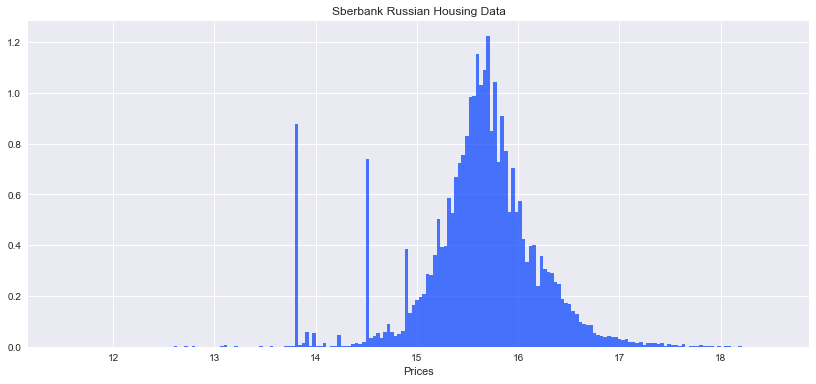

In [12]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(14, 6))

plt.hist(np.log(target_train), bins=200, normed=True, alpha=0.7)

plt.xlabel("Prices")
plt.title('Sberbank Russian Housing Data');

In [13]:
print ("Sberbank Russian Housing Dataset Statistics: \n")
print ("Number of houses = ", len(target_train))
print ("Number of features = ", len(list(features_train.keys())))
print ("Minimum house price = ", np.min(target_train))
print ("Maximum house price = ", np.max(target_train))
print ("Mean house price = ", "%.2f" % np.mean(target_train))
print ("Median house price = ", "%.2f" % np.median(target_train))
print ("Standard deviation of house prices =", "%.2f" % np.std(target_train))

Sberbank Russian Housing Dataset Statistics: 

Number of houses =  30471
Number of features =  33
Minimum house price =  100000
Maximum house price =  111111112
Mean house price =  7123035.28
Median house price =  6274411.00
Standard deviation of house prices = 4780032.89


## Fill in missing value

In [15]:
features_train.isnull().sum()

full_sq                                 0
num_room                             9572
floor                                 167
timestamp                               0
preschool_education_centers_raion       0
school_education_centers_raion          0
children_preschool                      0
children_school                         0
shopping_centers_raion                  0
healthcare_centers_raion                0
office_raion                            0
sport_objects_raion                     0
metro_min_walk                         25
public_transport_station_min_walk       0
railroad_station_walk_min              25
cafe_count_500                          0
kremlin_km                              0
workplaces_km                           0
ID_metro                                0
public_healthcare_km                    0
kindergarten_km                         0
school_km                               0
university_km                           0
museum_km                         

In [16]:
features_test.isnull().sum()

full_sq                               0
num_room                              0
floor                                 0
timestamp                             0
preschool_education_centers_raion     0
school_education_centers_raion        0
children_preschool                    0
children_school                       0
shopping_centers_raion                0
healthcare_centers_raion              0
office_raion                          0
sport_objects_raion                   0
metro_min_walk                       34
public_transport_station_min_walk     0
railroad_station_walk_min            34
cafe_count_500                        0
kremlin_km                            0
workplaces_km                         0
ID_metro                              0
public_healthcare_km                  0
kindergarten_km                       0
school_km                             0
university_km                         0
museum_km                             0
fitness_km                            0


In [17]:
df = pd.DataFrame(features_train, columns=X_list_num)
df['prices'] = target_train

df = df.dropna(subset=['num_room'])

df['metro_min_walk'] = df['metro_min_walk'].interpolate(method='linear')
features_test['metro_min_walk'] = features_test['metro_min_walk'].interpolate(method='linear')

df['railroad_station_walk_min'] = df['railroad_station_walk_min'].interpolate(method='linear')
features_test['railroad_station_walk_min'] = \
features_test['railroad_station_walk_min'].interpolate(method='linear')

df['floor'] = df['floor'].fillna(df['floor'].median())
len(df)

20899

## Categorical and Macro Features

In [19]:
ID_metro_cat = pd.factorize(df['ID_metro'])
df['ID_metro'] = ID_metro_cat[0]

In [20]:
ID_metro_pairs = dict(zip(list(ID_metro_cat[1]), list(set(ID_metro_cat[0]))))
ID_metro_pairs[224] = 219
features_test['ID_metro'].replace(ID_metro_pairs,inplace=True)

In [21]:
usdrub_pairs = dict(zip(list(macro['timestamp']), list(macro['usdrub'])))

In [23]:
df['timestamp'].replace(usdrub_pairs,inplace=True)
features_test['timestamp'].replace(usdrub_pairs,inplace=True)

In [24]:
df.rename(columns={'timestamp' : 'usdrub'}, inplace=True)
features_test.rename(columns={'timestamp' : 'usdrub'}, inplace=True)

## Displaying Correlation

In [25]:
pearson = df.corr(method='pearson')
corr_with_prices = pearson.ix[-1][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]]

full_sq                              0.593829
num_room                             0.476337
kremlin_km                          -0.290126
sport_objects_raion                  0.256412
ID_metro                             0.250502
university_km                       -0.222964
theater_km                          -0.222873
workplaces_km                       -0.220889
museum_km                           -0.203846
park_km                             -0.201636
metro_min_walk                      -0.200058
fitness_km                          -0.197702
school_education_centers_raion       0.193896
healthcare_centers_raion             0.185419
shopping_centers_km                 -0.182459
public_healthcare_km                -0.182388
ekder_all                            0.169331
school_km                           -0.158775
preschool_education_centers_raion    0.157762
office_raion                         0.149137
additional_education_km             -0.146074
raion_popul                       

## Scale, Shuffle and Split the Data

In [26]:
target_train = df['prices'].as_matrix()
features_train = df.drop('prices', 1).as_matrix()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, 
                                                    test_size = 0.2, random_state = 1)
X_train.shape, X_test.shape

((16719, 33), (4180, 33))

In [28]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

# Models

## 1. Regressors

In [29]:
def regression(regressor, x_train, x_test, y_train):
    reg = regressor
    reg.fit(x_train, y_train)
    
    y_train_reg = reg.predict(x_train)
    y_test_reg = reg.predict(x_test)
    
    return y_train_reg, y_test_reg

In [30]:
y_train_gbr, y_test_gbr = regression(GradientBoostingRegressor(n_estimators=330, 
                                                               max_depth=5, 
                                                               learning_rate=.1, 
                                                               min_samples_leaf=5, 
                                                               min_samples_split=5), 
                                     X_train, X_test, y_train)

y_train_br, y_test_br = regression(BaggingRegressor(n_estimators=33), 
                                   X_train, X_test, y_train)

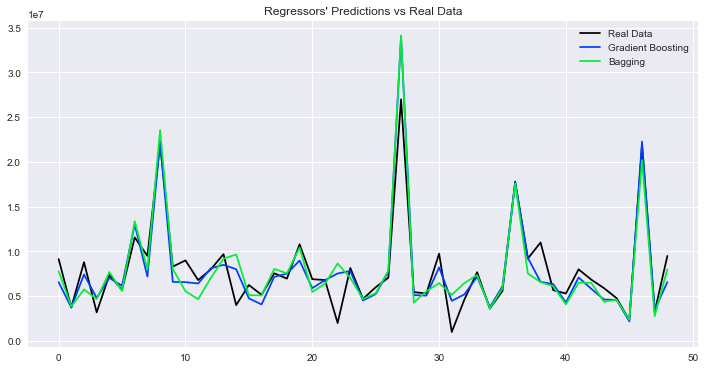

In [31]:
plt.figure(figsize = (12,6))

plt.plot(y_test[1:50], color = 'black', label='Real Data')

plt.plot(y_test_gbr[1:50], label='Gradient Boosting')
plt.plot(y_test_br[1:50], label='Bagging')

plt.legend()
plt.title("Regressors' Predictions vs Real Data"); 


## 2. Neural Network

In [33]:
def loss_plot(fit_history):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['mean_absolute_error'], label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'], label = 'test')

    plt.legend()
    plt.title('Mean Absolute Error'); 

In [34]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(128, input_dim=33, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu')) 
    
#    model.add(Dropout(0.1))
    
#    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
#    model.add(Dense(16, kernel_initializer='normal', activation='relu')) 
    
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [35]:
mlp_model = mlp_model()

mlp_history = mlp_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            nb_epoch=80, batch_size=16, verbose=0)

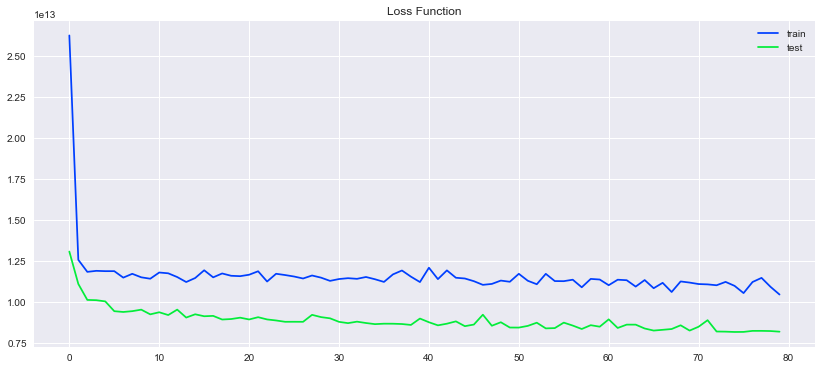

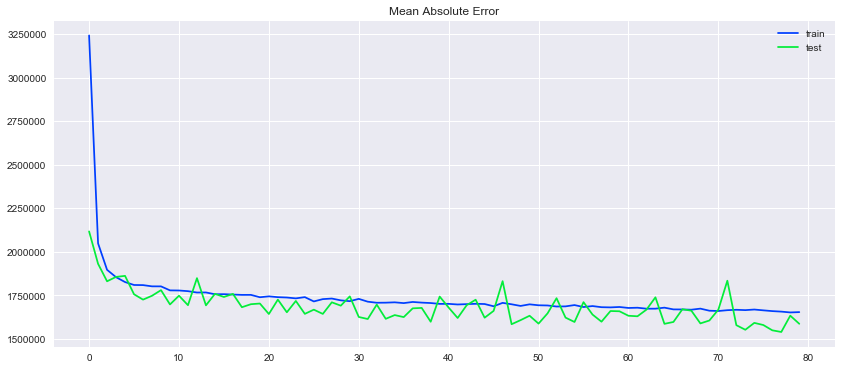

In [36]:
loss_plot(mlp_history)
mae_plot(mlp_history)

In [37]:
def mlp_model2():
    model = Sequential()
    
    model.add(Dense(512, input_dim=33, kernel_initializer='normal', activation='relu'))   
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))  
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.1))
    
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [38]:
mlp_model2 = mlp_model2()

mlp_history2 = mlp_model2.fit(X_train, y_train, validation_data=(X_test, y_test),
                            nb_epoch=80, batch_size=16, verbose=0)

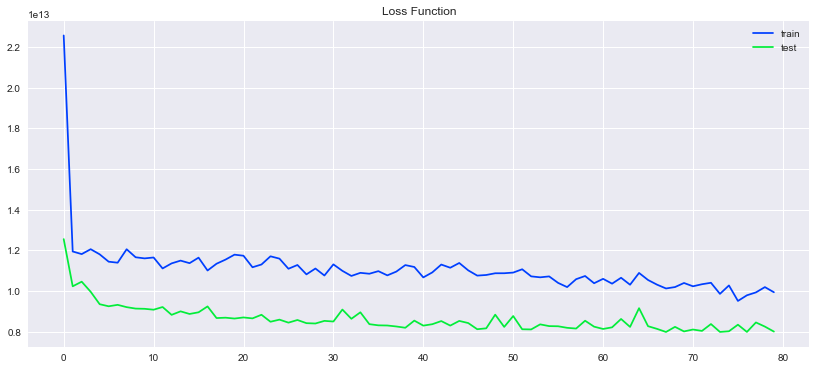

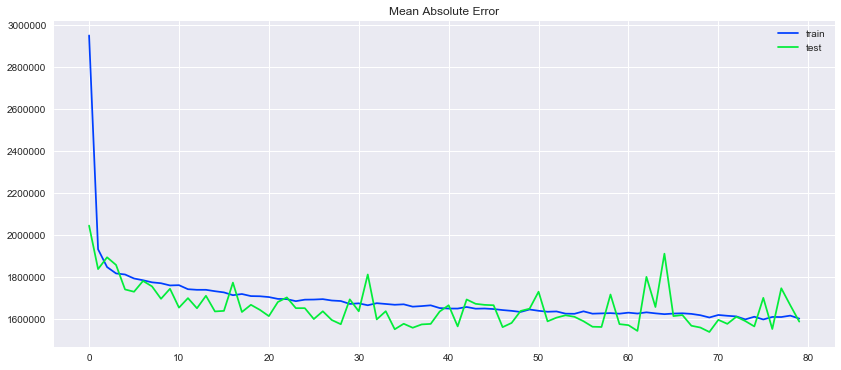

In [39]:
loss_plot(mlp_history2)
mae_plot(mlp_history2)

In [41]:
y_train_mlp = mlp_model.predict(X_train)
y_test_mlp = mlp_model.predict(X_test)

y_train_mlp2 = mlp_model2.predict(X_train)
y_test_mlp2 = mlp_model2.predict(X_test)

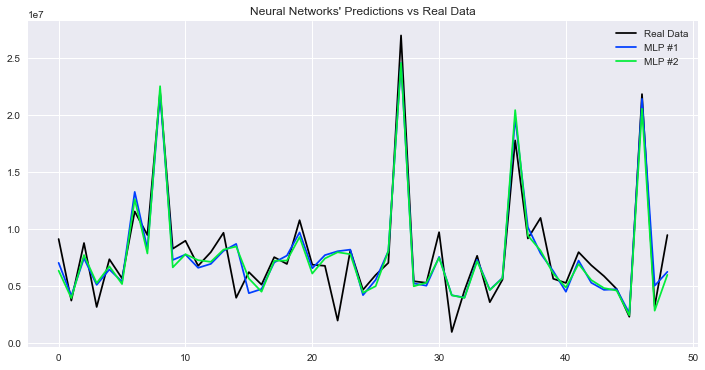

In [43]:
plt.figure(figsize = (12,6))

plt.plot(y_test[1:50], color = 'black', label='Real Data')

plt.plot(y_test_mlp[1:50], label='MLP #1')
plt.plot(y_test_mlp2[1:50], label='MLP #2')

plt.legend()
plt.title("Neural Networks' Predictions vs Real Data"); 

## 3.MLP Regressor

In [44]:
mlpr = MLPRegressor(hidden_layer_sizes=(198,), max_iter=200, solver='lbfgs', 
                    alpha=0.01, verbose=10)
mlpr.fit(X_train, y_train);

In [45]:
y_train_mlpr = mlpr.predict(X_train)
y_test_mlpr = mlpr.predict(X_test)

# Evaluation Metrics
####  explained variance regression score
#### coefficient of determination
#### mean squared error
#### mean absolute error
#### median absolute error

In [46]:
def scores(regressor, y_train, y_test, y_train_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))

## 1. Regressor

In [47]:
scores('Gradient Boosting Regressor', y_train, y_test, y_train_gbr, y_test_gbr)
scores('Bagging Regressor', y_train, y_test, y_train_br, y_test_br)

_______________________________________
Gradient Boosting Regressor
_______________________________________
EV score. Train:  0.8919554511
EV score. Test:  0.69964946309
---------
R2 score. Train:  0.8919554511
R2 score. Test:  0.699259999312
---------
MSE score. Train:  2.54647940231e+12
MSE score. Test:  7.79870379364e+12
---------
MAE score. Train:  996196.893804
MAE score. Test:  1499737.61201
---------
MdAE score. Train:  552431.193979
MdAE score. Test:  763872.805855
_______________________________________
Bagging Regressor
_______________________________________
EV score. Train:  0.95213036147
EV score. Test:  0.689342403589
---------
R2 score. Train:  0.952089236342
R2 score. Test:  0.689164633515
---------
MSE score. Train:  1.12919878001e+12
MSE score. Test:  8.06049393583e+12
---------
MAE score. Train:  548302.727988
MAE score. Test:  1509967.88092
---------
MdAE score. Train:  233636.363636
MdAE score. Test:  743923.924242


## 2. Neural Network

In [48]:
scores('MLP Model #1', y_train, y_test, y_train_mlp, y_test_mlp)
scores('MLP Model #2', y_train, y_test, y_train_mlp2, y_test_mlp2)

_______________________________________
MLP Model #1
_______________________________________
EV score. Train:  0.555796888775
EV score. Test:  0.685265271424
---------
R2 score. Train:  0.554593432268
R2 score. Test:  0.684253461609
---------
MSE score. Train:  1.04976943486e+13
MSE score. Test:  8.18784904286e+12
---------
MAE score. Train:  1544626.27776
MAE score. Test:  1587292.04217
---------
MdAE score. Train:  769022.75
MdAE score. Test:  861324.75
_______________________________________
MLP Model #2
_______________________________________
EV score. Train:  0.603906069922
EV score. Test:  0.691457039557
---------
R2 score. Train:  0.603889112037
R2 score. Test:  0.691400387426
---------
MSE score. Train:  9.33585477009e+12
MSE score. Test:  8.00251700404e+12
---------
MAE score. Train:  1522000.48797
MAE score. Test:  1585393.00449
---------
MdAE score. Train:  776123.0
MdAE score. Test:  869576.0


## 3. MLP Regressor

In [49]:
scores('MLP Regressor', y_train, y_test, y_train_mlpr, y_test_mlpr)

_______________________________________
MLP Regressor
_______________________________________
EV score. Train:  0.746875948118
EV score. Test:  0.668034308971
---------
R2 score. Train:  0.746872961778
R2 score. Test:  0.66801316525
---------
MSE score. Train:  5.96589828515e+12
MSE score. Test:  8.6089877691e+12
---------
MAE score. Train:  1456424.90212
MAE score. Test:  1597750.22367
---------
MdAE score. Train:  775538.270459
MdAE score. Test:  850244.492724


# Predictions

In [50]:
scale = StandardScaler()
features_train = scale.fit_transform(features_train)
features_test = scale.fit_transform(features_test.as_matrix())

In [51]:
reg = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=.1, 
                                min_samples_leaf=5, min_samples_split=5)
reg.fit(features_train, target_train)

target_train_predict = reg.predict(features_train)
target_test_predict = reg.predict(features_test)

In [52]:
print("_______________________________________")
print("Gradient Boosting  Regressor")
print("_______________________________________")
print("EV score. Train: ", explained_variance_score(target_train, target_train_predict))
print("---------")
print("R2 score. Train: ", r2_score(target_train, target_train_predict))
print("---------")
print("MSE score. Train: ", mean_squared_error(target_train, target_train_predict))
print("---------")
print("MAE score. Train: ", mean_absolute_error(target_train, target_train_predict))
print("---------")
print("MdAE score. Train: ", median_absolute_error(target_train, target_train_predict))

_______________________________________
Gradient Boosting  Regressor
_______________________________________
EV score. Train:  0.818760332726
---------
R2 score. Train:  0.818760332726
---------
MSE score. Train:  4.35734484709e+12
---------
MAE score. Train:  1258912.5809
---------
MdAE score. Train:  658595.676637


# Submission

In [54]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
target_predict = ["{0:.2f}".format(x) for x in target_test_predict]

submission = pd.DataFrame({"id": test['id'], "price_doc": target_predict})
print(submission[0:5])

submission.to_csv('kaggle_sberbank_housing.csv', index=False)

      id   price_doc
0  30474  4907497.85
1  30475  8032663.99
2  30476  5533251.45
3  30477  5459247.06
4  30478  4847240.59


In [ ]:
s